In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.vision.all import *
from utils import *
import sklearn.metrics as skm
from tqdm.notebook import tqdm

In [3]:
conf = {
    'bs':180,
    'emb_size':256,
    'arch':resnet34,
    'split':1
}

In [4]:
train_df = pd.read_csv(PATH/'train_split.csv')
train_df['is_valid'] = train_df.split==conf['split']

In [5]:
# def hash_label(x):
#     x = (13*x)%10000
#     return x // 2000
# train_df['split']=train_df.label_group.apply(hash_label)
# train_df.to_csv(PATH/'train_split.csv')

In [6]:
data_block = DataBlock(blocks = (ImageBlock(), CategoryBlock(vocab=train_df.label_group.to_list())),
                 splitter=ColSplitter(),
                 #splitter=RandomSplitter(),
                 get_y=ColReader('label_group'),
                 get_x=ColReader('image', pref=PATH/'train_images'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75),
                 )
dls = data_block.dataloaders(train_df, bs=conf['bs'],num_workers=16)

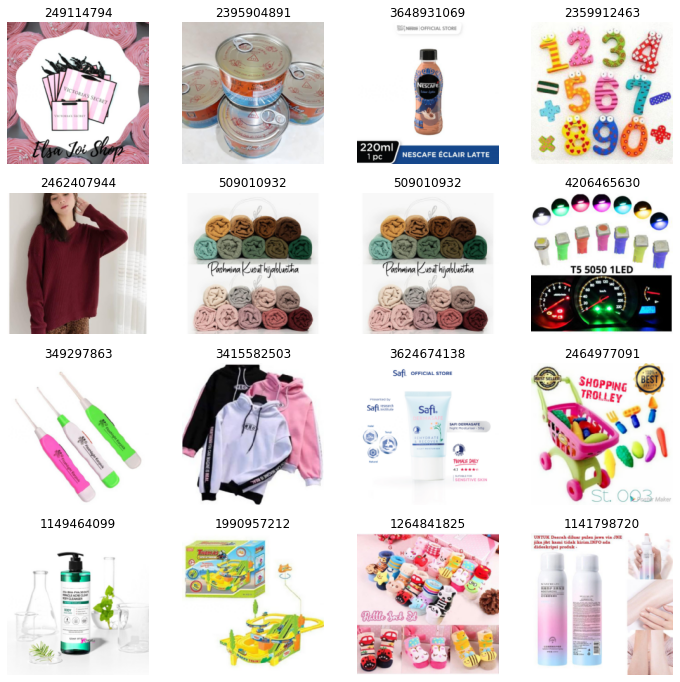

In [7]:
dls.valid.show_batch(max_n=16)

In [8]:
def emb_sim(inp):
    #norms=inp.norm(2,dim=1)
    #normal_inp = inp /norms[:,None]
    normal_inp=F.normalize(inp)
    return normal_inp @ normal_inp.T

In [9]:
def f1_from_embs(x, y):
    
    res =0
    all_labels = set(y.tolist())
    freqs = {lb: (y==lb).sum() for lb in all_labels}
    for preds, group in zip(preds_groups,y.tolist()):
        
        correct = preds.count(group)
        all_matches = freqs[group]
        met = 2.0 * correct / (all_matches + len(preds))
        #print(correct, all_matches, met)
        res+=met
    return res / len(preds_groups)


In [10]:
def groups_from_embs(x, treshold=0.9):
    sims = emb_sim(x)
    preds_groups=[]
    for i in range(len(sims)):
        tops= torch.where(sims[i]>treshold)[0]
        preds_groups.append(tops)
    return preds_groups

In [11]:
def embs_from_resnet(model, dl):
    model_stem =list(learn.model.children())[0].eval()
    pipeline = nn.Sequential(model_stem, AdaptiveConcatPool2d(), Flatten())
    all_embs = []
    all_ys=[]
    for batch in tqdm(dl):
        if len(batch) ==2:
            bx,by=batch
        else:
            bx,=batch
            by=torch.zeros(1)
        with torch.no_grad():
            embs = pipeline(bx)
            all_embs.append(embs.half())
        all_ys.append(by)
    return torch.cat(all_embs), torch.cat(all_ys)

In [12]:
def f1metric(inp, targ):
    pred = inp.argmax(dim=1)
    return skm.f1_score(targ, pred,average=None).sum() / torch.unique(targ).numel()

In [13]:
learn = cnn_learner(dls,conf['arch'], metrics=[accuracy, AccumMetric(f1metric, flatten=False)])

In [14]:
learn.fine_tune(4,1e-2)

epoch,train_loss,valid_loss,accuracy,f1metric,time
0,7.884692,10.438197,0.000000,0.000000,01:05


epoch,train_loss,valid_loss,accuracy,f1metric,time
0,5.966698,10.067314,0.000000,0.000000,01:14
1,4.787946,11.064590,0.000000,0.000000,01:14
2,2.453009,11.977497,0.000000,0.000000,01:14
3,0.988158,12.209515,0.000000,0.000000,01:13


In [15]:
learn.save('resnet34')

Path('models/resnet34.pth')

# VALIDATION STATS

In [16]:
valid_df = dls.valid_ds.items
valid_df.reset_index()[:3]

,index,Unnamed: 0,posting_id,image,image_phash,title,label_group,split,is_valid
0,0,0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,1,True
1,2,2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,1,True
2,4,4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,1,True


In [17]:
def groups(preds):
    matches = preds[:,None]==preds[None,:]
    groups = [torch.where(matches[i])[0] for i in range(len(matches))]
    return groups
groups(torch.tensor([1,2,2,2,3,1]))

[tensor([0, 5]),
 tensor([1, 2, 3]),
 tensor([1, 2, 3]),
 tensor([1, 2, 3]),
 tensor([4]),
 tensor([0, 5])]

In [18]:
def f1_score(pred_groups, real_groups):
    res =0
    for pred, real in zip(pred_groups, real_groups):
        #print(pred, real)
        inter = set(pred.tolist()).intersection(set(real.tolist()))
        #print(inter)
        res += 2 * len(inter) / (len(pred)+len(real))
    return res / len(pred_groups)

In [19]:
%%time
embs, y = embs_from_resnet(learn.model, dls.valid)

  0%|          | 0/38 [00:00<?, ?it/s]

CPU times: user 4.87 s, sys: 1.32 s, total: 6.19 s
Wall time: 11.3 s


In [20]:
%%time
x,y=learn.get_preds()

CPU times: user 5.86 s, sys: 1.81 s, total: 7.67 s
Wall time: 11.5 s


In [21]:
preds =x.argmax(dim=1)

In [22]:
pred_groups = groups(preds)
real_groups = groups(y)
pred_groups[:5]

[tensor([   0, 2289, 3450, 3587, 4515, 6526, 6540, 6724]),
 tensor([   1, 3627]),
 tensor([2]),
 tensor([  3, 981, 982]),
 tensor([4])]

In [23]:
real_groups[:5]

[TensorCategory([   0, 6576]),
 TensorCategory([   1, 3162]),
 TensorCategory([   2, 3686]),
 TensorCategory([  3, 981, 982]),
 TensorCategory([   4, 2862, 2863])]

In [24]:
f1_score(pred_groups, real_groups)

0.5536615046624601

In [25]:
embs.shape

torch.Size([6798, 1024])

In [28]:
emb_groups = groups_from_embs(embs,0.9)
emb_groups[:5]

[TensorBase([0], device='cuda:0'),
 TensorBase([1], device='cuda:0'),
 TensorBase([   2, 3686], device='cuda:0'),
 TensorBase([  3, 981, 982], device='cuda:0'),
 TensorBase([4], device='cuda:0')]

In [29]:
f1_score(emb_groups, real_groups)

0.7244612530750745

# Test 

In [43]:
fake_test_df = train_df[['posting_id', 'image', 'image_phash', 'title']]

In [44]:
fake_test_df = pd.concat([fake_test_df, fake_test_df])

In [45]:
fake_test_df

,posting_id,image,image_phash,title
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DOUBLE FOAM TAPE"
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Campur - Leher Kancing (DPT001-00) Batik karakter Alhadi
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml
...,...,...,...,...
34245,train_4028265689,fff1c07ceefc2c970a7964cfb81981c5.jpg,e3cd72389f248f21,Masker Bahan Kain Spunbond Non Woven 75 gsm 3 ply lapis Bisa Dicuci
34246,train_769054909,fff401691371bdcb382a0d9075dfea6a.jpg,be86851f72e2853c,MamyPoko Pants Royal Soft - S 70 - Popok Celana
34247,train_614977732,fff421b78fa7284284724baf249f522e.jpg,ad27f0d08c0fcbf0,KHANZAACC Robot RE101S 1.2mm Subwoofer Bass Metal Wired Headset
34248,train_3630949769,fff51b87916dbfb6d0f8faa01bee67b8.jpg,e3b13bd1d896c05c,"Kaldu NON MSG HALAL Mama Kamu Ayam Kampung , Sapi Lokal, Jamur (Bkn Alsultan / Biocell)"


In [46]:
test_dl = dls.test_dl(fake_test_df)

In [64]:
embs, _ = embs_from_resnet(learn.model, test_dl)

  0%|          | 0/381 [00:00<?, ?it/s]

In [65]:
embs.shape

torch.Size([68500, 1024])

In [66]:
emb_groups = groups_from_embs(embs)


In [81]:
def matches(group, data):
    return ' '.join([data.iloc[x.cpu().item()].posting_id for x in group])

In [82]:
matches(emb_groups[1], fake_test_df)

'train_3386243561 train_1816968361 train_2120597446 train_3423213080 train_3805508898 train_3386243561 train_1816968361 train_2120597446 train_3423213080 train_3805508898'

In [97]:
%%time
m = [matches(g, fake_test_df) for g in emb_groups]

CPU times: user 2.25 s, sys: 10.5 ms, total: 2.26 s
Wall time: 2.26 s


In [85]:
fake_test_df['matches']=m

In [86]:
fake_test_df.head()

,posting_id,image,image_phash,title,matches
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,train_129225211 train_129225211
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DOUBLE FOAM TAPE",train_3386243561 train_1816968361 train_2120597446 train_3423213080 train_3805508898 train_3386243561 train_1816968361 train_2120597446 train_3423213080 train_3805508898
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,train_2288590299 train_2288590299
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Campur - Leher Kancing (DPT001-00) Batik karakter Alhadi,train_2406599165 train_1593362411 train_2406599165 train_1593362411
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,train_3369186413 train_921438619 train_3369186413 train_921438619
